In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
use_cuda = torch.cuda.is_available()

In [47]:
class DSet(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step))
        self.target = np.zeros(len(samples), dtype=np.float32)
        for i, sample in enumerate(samples):
            raw = json.load(open(sample))
            begin = raw[0]['t']
            span = list(map(lambda x: max(0, x['t'] - begin) + 1, raw))
            volumn = map(lambda x: int(x * step / 8.1), np.log10(span))
            for item in volumn:
                self.data[i][item] += 1
            if 'rumor' in sample:
                self.target[i] = 1

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).float(), self.target[idx]


In [95]:
class DSet(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step))
        self.target = np.zeros(len(samples), dtype=np.float32)
        raw_data = json.load(open('prop_span.json'))
        for i, sample in enumerate(samples):
            span = raw_data[sample]
            volumn = map(lambda x: int(x * step / 8.1), np.log10(span))
            for item in volumn:
                self.data[i][item] += 1
            if 'rumor' in sample:
                self.target[i] = 1

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).float(), self.target[idx]

In [108]:
class DCNN(torch.nn.Module):

    def __init__(self, D_in):
        super(CNN, self).__init__()
        self.conv11 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv12 = nn.Conv1d(8, 8, 3, padding=1)
        self.conv21 = nn.Conv1d(8, 16, 3, padding=1)
        self.conv22 = nn.Conv1d(16, 16, 3, padding=1)
        self.conv31 = nn.Conv1d(16, 32, 3, padding=1)
        self.conv32 = nn.Conv1d(32, 32, 3, padding=1)
        # self.conv4 = nn.Conv1d(32, 64)
        self.fc_in = D_in // 8 * 32
        self.fc1 = nn.Linear(self.fc_in, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(F.max_pool1d(self.conv12(x), 2))
        x = F.relu(self.conv21(x))
        x = F.relu(F.max_pool1d(self.conv22(x), 2))
        x = F.relu(self.conv31(x))
        x = F.relu(F.max_pool1d(self.conv32(x), 2))
        x = F.dropout(x.view(-1, self.fc_in))
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.sigmoid(x)

In [105]:
class CNN(torch.nn.Module):

    def __init__(self, D_in):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1)
        # self.conv3 = nn.Conv1d(16, 32)
        # self.conv4 = nn.Conv1d(32, 64)
        self.fc_in = D_in // 4 * 16
        self.fc1 = nn.Linear(self.fc_in, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.dropout(x.view(-1, self.fc_in))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)

In [96]:
samples = glob('rumor/*.json') + glob('truth/*.json')
train_data, test_data = train_test_split(samples, test_size=0.2, random_state=42)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(DSet(train_data, 100), batch_size=128, **kwargs)
test_loader = DataLoader(DSet(test_data, 100), batch_size=128, **kwargs)

In [97]:
import matplotlib.pyplot as plt

In [98]:
len(train_data), len(test_data)

(3731, 933)

In [106]:
def train(nbatch):
    
    model = CNN(100)
    if use_cuda:
        model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters())

    ret = []
    for epoch in range(40):
        # print('Epoch %03d:' % (epoch + 1))
        train_loss, test_loss, tr_acc, val_acc = 0.0, 0.0, 0.0, 0.0
        model.train()
        for i, (data, target) in enumerate(train_loader):
            if i >= nbatch:
                break
            data = data.view(data.size(0), 1, data.size(1))
            target = target.view(target.size(0), 1)
            optimizer.zero_grad()
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp_(min=0)
            tr_acc += pred.eq(target.data).cpu().sum()
        # train_loss /= len(train_loader.dataset)
        # tr_acc = tr_acc / len(train_loader.dataset) * 100
        # print('tr_loss %.6f | tr_acc %.2f%%' % (train_loss, tr_acc))

        model.eval()
        for data, target in test_loader:
            data = data.view(data.size(0), 1, data.size(1))
            target = target.view(target.size(0), 1)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp_(min=0)
            val_acc += pred.eq(target.data).cpu().sum()
        test_loss /= len(test_loader.dataset)
        val_acc = val_acc / len(test_loader.dataset) * 100
        # print('val_loss %.6f | val_acc %.2f%%' % (test_loss, val_acc))
        ret.append(val_acc)
    return ret

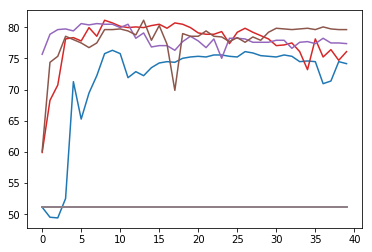

In [107]:
data = {}
plt.figure()
for i in range(2, 31, 4):
    data[i] = train(i)
    plt.plot(data[i], label=str(i))